# **Libraries**

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import f1_score,accuracy_score,roc_curve,auc
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore",category = FutureWarning)
warnings.filterwarnings("ignore",category= DeprecationWarning)

# **Data Exploration**

## Import dataset

In [2]:
df = pd.read_csv("sentiment.tsv",sep = "\t")
df.columns = ['label','body_text']
df.sample(5)

,label,body_text
1712,pos,late nite tv work in exactly 12 hours
905,neg,"@paulzonca yah, thats how much of my lsl goes"
299,neg,i dont know what i am going to do.
1588,pos,@Zoe39 lol im a good boy most of the time
1390,neg,@sandyd33 It was a baby girl!! Little Annie O'...


In [3]:
df.columns

Index(['label', 'body_text'], dtype='object')

In [4]:
df.describe()

,label,body_text
count,2000,2000
unique,2,2000
top,pos,@JoSmoke Just finished my errands and about to...
freq,1016,1


## Encondig Labels
- Encode target labels with value between 0 and n_classes-1.

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
df.sample(5)

,label,body_text
704,1,@StarJonesEsq Good NightStar xo All Gods Bless...
616,1,@ABZQuine if you want my advice do NOT cycle b...
166,1,@DanMerriweather That is so mean but I agree ...
1142,1,@amyshell gotcha
1876,1,@runnerkara Tell me about it. I guess that's w...


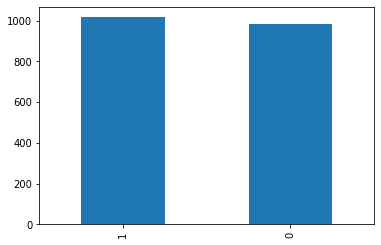

In [6]:
df['label'].value_counts().plot.bar()

# Clearning of Data

In [7]:
def remove_pattern(input_txt,pattern):
    r = re.findall(pattern,input_txt)
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    return input_txt

## Remove users name (@user)

In [8]:
df['tweet'] = np.vectorize(remove_pattern)(df['body_text'],"@[\w]*")
df.head()

,label,body_text,tweet
0,1,having a vodka tonic and looking forward to go...,having a vodka tonic and looking forward to go...
1,1,@ddlovatofans1neg1 Could you follow me please....,Could you follow me please.I would really app...
2,1,@jordanknight for once.................. PLEAS...,for once.................. PLEASE TELL US WHY...
3,0,Had a dream about a walk in fast food resturau...,Had a dream about a walk in fast food resturau...
4,1,@TroyBrownBBNews Yes... For a &quot;friend&quot;,Yes... For a &quot;friend&quot;


## Remove special characters, numbers, punctuations¶
- Regular expression has used

In [9]:
df['tweet'] = df['tweet'].str.replace("[^a-zA-Z#]"," ")
df.head()

,label,body_text,tweet
0,1,having a vodka tonic and looking forward to go...,having a vodka tonic and looking forward to go...
1,1,@ddlovatofans1neg1 Could you follow me please....,Could you follow me please I would really app...
2,1,@jordanknight for once.................. PLEAS...,for once PLEASE TELL US WHY...
3,0,Had a dream about a walk in fast food resturau...,Had a dream about a walk in fast food resturau...
4,1,@TroyBrownBBNews Yes... For a &quot;friend&quot;,Yes For a quot friend quot


# NPL

## Tokenized Process

In [11]:
token = df['tweet'].apply(lambda x: x.split())
token.head()

0    [having, a, vodka, tonic, and, looking, forwar...
1    [Could, you, follow, me, please, I, would, rea...
2    [for, once, PLEASE, TELL, US, WHY, u, were, th...
3    [Had, a, dream, about, a, walk, in, fast, food...
4                    [Yes, For, a, quot, friend, quot]
Name: tweet, dtype: object

### Stemmers remove morphological affixes from words, leaving only the word stem

- We'ra use the __Porter Stemmer__. It follows the algorithm presented in __Porter, M__. *"An algorithm for suffix stripping."* Program 14.3 (1980): 130-137.

- Martin Porter, the algorithm's inventor, maintains a web page about the algorithm at http://www.tartarus.org/~martin/PorterStemmer/

In [13]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
token = token.apply(lambda x: [stemmer.stem(i) for i in x]) 
token.head()

0    [have, a, vodka, tonic, and, look, forward, to...
1    [could, you, follow, me, pleas, I, would, real...
2    [for, onc, pleas, tell, US, whi, u, were, thin...
3    [had, a, dream, about, a, walk, in, fast, food...
4                     [ye, for, a, quot, friend, quot]
Name: tweet, dtype: object